# Mini-Project: A Simple Search Engine from Scratch
In this mini-project you will study the fundaments of IR.

The mini-project is divided as follow:

- **Week 1**: Study the provided notebook. Using the VSM retrieval model, run experiments *(section 4)* with the provided collection. Compute the metrics MAP, P10 and precision-recall curves.

- **Week 2**: Implement the LMD and LMJM retrieval models and repeat the experiments with the new models. Compare it to the previous retrieval models.

- **Week 3**: Implement the RM3 retrieval model and repeat the experiments with the new models. Compare it to the previous retrieval models.

- **Week 4**: Implement the BM25 retrieval model and repeat the experiments with the new models. Compare it to the previous retrieval models.

**Submission date: 15 October**

## 1. Vector Space Model

In the vector space model, documents are represented as a vector $d_j=(w_{d_j,1},w_{d_j,2}, ..., w_{d_j,n})$ of $n$ word frequencies -- most of the words are equal to 0. Queries are also represented as a vector of words $q_j=(w_{q_j,1},w_{q_j,2}, ..., w_{q_j,n})$. In the vector space model, each document word is weighted by their *tf-idf*

$${tf-idf} = tf*\frac{|D|}{log (df(w_a))}$$

The vector space model is based on the cosine similarity, which measures the angle between the two vectors in the 1-unit sphere:

$$cos(q,d) = \frac{\sum_t q_t\cdot d_t}{\sqrt{\sum_t q^2_t}\cdot \sqrt{\sum_t d^2_t }}$$


Below you can read the corresponding matricial implementation for multiple documents.

### Parser
Using the CountVectorizer class of Scikit-Learn, try the different parser options by generating unigrams and bigrams with different stop words.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#instancia um objeto com a função CountVectorizer
vectorizer = CountVectorizer()

#instancia um objeto com a função CountVectorizer com parametros definidos
#ngram_range: define os limites do tamanho dos n-grams a incluir na tokenização
#stop_words: palavras a ignorar (são palavras comuns nos documentos, não oferecem nenhum valor adicional)
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', 
                                    min_df=1, stop_words = {'the', 'is'})

#lista de documentos
corpus = ['This is the first document.',
'This is the second second document.',
'And the third one.',
'Is this the first document?', ]

In [ ]:
#instacia um objeto com uma função que lida com o pré-processamento e tokenização
uni_analyze = vectorizer.build_analyzer()

#pré-processa e tokeniza a string dada (ignora palavras com menos de duas letras e pontuação)
uni_analyze("This is a text document to analyze.")

In [ ]:
#instacia um objeto com uma matriz com informação acerca da frequencia das palavras em cada documento de corpus
tf_uni = vectorizer.fit_transform(corpus).toarray()

#mostra os tokens correspondente a cada coluna da matriz
print(vectorizer.get_feature_names())

print()

#matriz das frequências de palavras por documento
#cada linha é respeitante a um documento
#cada coluna é respeitante a um token (palavra no caso uni-gram)
print(tf_uni)

In [ ]:
#Test
coln=vectorizer.get_feature_names()
df=pd.DataFrame(vectorizer.fit_transform(corpus).toarray(),columns=coln)
df

In [ ]:
''''Separates the words, ignores stop word "the" and "is",it also reads the document one time separating each of the words,
then a second time separating in 2 words due to the n-gram_range(1,2)''' 

#instacia um objeto com uma função que lida com o pré-processamento e tokenização
bi_analyze = bigram_vectorizer.build_analyzer()

#pré-processa e tokeniza a string dada de acordo com os parâmetros definidos anteriormente (bi-gram)
bi_analyze("This is a text document to analyze.") 

In [ ]:
"""Creates another sparce matrix using the bigram_vectorizer method, this one is bigger than the first method because the additional
2-gram sparsing, it searches the document in 1-grams first then the bigrams """

#instacia um objeto com uma matriz com informação acerca da frequencia das palavras em cada documento de corpus
tf_bi = bigram_vectorizer.fit_transform(corpus).toarray()

#mostra os tokens correspondente a cada coluna da matriz
print(bigram_vectorizer.get_feature_names())

print()

#matriz das frequências de palavras por documento
#cada linha é respeitante a um documento
#cada coluna é respeitante a um token (palavra no caso uni-gram)
print(tf_bi)

In [ ]:
#mostra informação acerca da frequência do token dado no corpus
bigram_vectorizer.vocabulary_.get('document')

### TF IDF and the cosine similarity

In [ ]:
termCollFreq = np.sum(tf_uni != 0, axis = 0) #frequencia de cada palavra no conjunto dos documentos
docLen = np.sum(tf_uni, axis = 1) #numero total de palavras no conjunto dos documentos

idf = np.log(np.size(corpus)/termCollFreq) #indice de raridade de cada palavra
idf_rows = np.dot(np.ones((np.size(corpus),1)), idf.reshape(1,np.size(idf)))
tfidf = tf_uni*idf_rows  #peso final de cada palavra em cada documento

docNorms = np.sqrt(np.sum(np.power(tfidf,2), axis = 1)) #norma de cada documento
        
print("\ntf:\n", tf_uni)
print("\nidf:\n", idf)
print("\ntfidf:\n", tfidf)
print("\ndocnorms:\n", docNorms)

In [ ]:
query = 'document'
#checks each column of the features and only keeps the ones that are equal to the query
query_vector = vectorizer.transform([query]).toarray()
#Norm of the created vector
queryNorm = np.sqrt(np.sum(np.power(query_vector, 2), axis = 1))

#Scores the query_vector for each document.
#The second document has the same frequencie of the word document as the first and forth, but due to a bigger docNorm because,
#this document has more words and the score is lower.
doc_scores = np.dot(query_vector, tfidf.T)/(docNorms*queryNorm)

print(doc_scores)

In [ ]:
#Test
q_df=pd.DataFrame(vectorizer.transform([query]).toarray(),columns=coln)
print(q_df[q_df!=0].dropna(axis=1).columns)
#range(1:(np.sum(q_df.values)))
#np.sum(q_df,axis=1)

### Inverted Index
The matricial implementation is not scalable because it computes the similarity for all documents in the collection. However, one should only compute the similarity for the documents containing the query words. This is where the inverted index comes to our rescue.

Read the inverted index implementation presented next. Describe in your own words how the cosine similarity should be implemented with the inverted index:


In [ ]:
features = vectorizer.get_feature_names()

#Creates a dictionary whit the posting lists and the feature names
i = 0
inverted_index = dict()
for token in features:
    print("==== Creating the posting list for token \"", token, "\"")
    docs_with_token = np.where(tf_uni[:,i] != 0)
    len = np.size(docs_with_token,1)
    
    postings_matrix = np.concatenate([tf_uni[docs_with_token,i], docs_with_token])
    postings_list = list(map(tuple, postings_matrix.T))
    inverted_index[token] = postings_list
    # each line shows the frequencie of the word and the the correspondent document where the word was found
    # this is used to map the information on the database.
    print(postings_list)
    i = i + 1

### Evaluation
Using the Vector Space Model, run the experiments of section 4.

We advice you to use an external Python IDE for editing more complex implementations. **The Notebook should be used as a notebook, not as an IDE**. Your implementations should be organized on external classes as below:

In [ ]:
import RetrievalModelsMatrix as b

aa = b.RetrievalModelsMatrix(tf_uni, vectorizer)
#unfinished in retrieval methods 
#aa.score_lmd("document",1)

### Precision-Recall Curve

In [ ]:
import MeanAveragePrecision as m
bb=m.MeanAveragePrecision(tf_uni,vectorizer)

print(bb.cumulative_pscore('second'))  #Will be used to determine the precision recall curve
bb.recall('second')   

In [ ]:
bb.pr_curve('document')

## 2. Retrieval Models

In this section you will implement three of the most popular retrieval model. After finishing each retrieval model implementation, run the experiments of section 4 with the new model.

### Language Model with Jelineck-Mercer Smoothing (20%)
The family of Language Models for retrieval build on the density distribution of the terms over each document and the density distribution of terms over the collection of documents.

There several ways of avoiding the zero probabilities problem with term smoothing.  The Jelineck-Mercer smoothing model uses a mixture of probabilities between the document model $M_d$ and the corpus model $M_c$:

$$p(q|d,C)= \lambda \cdot p(q|M_d) + (1-\lambda)\cdot p(q|M_c)$$

Implement the LMJM retrieval model using the matricial definitions:

In [ ]:
# p(q|Md) = probabilidade do termo da query aparecer no documento d =
#         = nr vezes termo t no doc / nr total de termos do doc

# p(q|Mc) = probabilidade do termo da query no corpus =
#         = nr vezes termo t no corpus / nr total de termos do corpus

In [1]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

lam = 0.5; print("lam:",lam) #escolher o lambda ---> lambda

corpus = ['Jackson one most talented entertainers all time',
          'Michael Jackson anointed himself King Pop']
print("\ncorpus:",corpus)

tf = vectorizer.fit_transform(corpus).toarray(); #numero de vezes que cada token aparece em cada documento ---> f_td
print("\ntf:"); print(tf)

query = "Michael Jackson"; query_vector = vectorizer.transform([query]).toarray();
print("\nquery_vector:",query_vector)


#numero de tokens no corpus (soma da soma colunas da matriz tf)
total_tokens_corpus = sum(np.sum(tf,axis=0)); print("\ntotal_tokens_corpus:", total_tokens_corpus)

#frequencia de cada token no corpus (soma de cada coluna da tf a dividir pelo numero total de tokens do corpus) ---> Mc(t)
Mc = np.sum(tf,axis=0) / total_tokens_corpus ; print("\nMc:",Mc)

#numero de tokens em cada documento (soma de cada linha da matriz tf)  ---> |d|
tokens_per_doc  = np.sum(tf,axis=1); print("\ntokens_per_doc:",tokens_per_doc)


#Calculo dos scores

#probabilidades
Pd = tf / tokens_per_doc[:,None]; print("\nPd:", Pd)
Pc = Mc; print("\nPc:", Pc)

#elevar ao vetor da query (query_vector) ---> P(t|Md,Mc) ^ q(t)
Ed = np.power(Pd, query_vector); print("\nEd:", Ed)
Ec = np.power(Pc, query_vector); print("\nEc:", Ec)

#produto das probabilidades ---> produtorio( P(t|Md,Mc)^ q(t) )
scores = np.prod(lam*Ed + (1-lam)*Ec, axis=1)
print("\nscores:",scores)


#compara os resultados com os documentos do corpus para ver se fazem sentido
print("\nquery:", query)
print("corpus:", corpus)

lam: 0.5

corpus: ['Jackson one most talented entertainers all time', 'Michael Jackson anointed himself King Pop']

tf:
[[1 0 1 0 1 0 0 1 1 0 1 1]
 [0 1 0 1 1 1 1 0 0 1 0 0]]

query_vector: [[0 0 0 0 1 0 1 0 0 0 0 0]]

total_tokens_corpus: 13

Mc: [0.07692308 0.07692308 0.07692308 0.07692308 0.15384615 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308]

tokens_per_doc: [7 6]

Pd: [[0.14285714 0.         0.14285714 0.         0.14285714 0.
  0.         0.14285714 0.14285714 0.         0.14285714 0.14285714]
 [0.         0.16666667 0.         0.16666667 0.16666667 0.16666667
  0.16666667 0.         0.         0.16666667 0.         0.        ]]

Pc: [0.07692308 0.07692308 0.07692308 0.07692308 0.15384615 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308]

Ed: [[1.         1.         1.         1.         0.14285714 1.
  0.         1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         0.

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import RetrievalModelsMatrix as b

corpus = ['Jackson one most talented entertainers all time',
          'Michael Jackson anointed himself King Pop']

query = "Michael Jackson"

vectorizer = CountVectorizer()
tf = vectorizer.fit_transform(corpus).toarray()
query_vector = vectorizer.transform([query]).toarray()

aa = b.RetrievalModelsMatrix(tf, vectorizer)

doc_scores=aa.score_lmjm(query,0.5)

print(doc_scores)

[0.00570579 0.01951802]


Implement the LMJM retrieval model using the inverted-index data structures:

In [ ]:
query = "document"

# TO DO: LMJM model

print(doc_scores)

### Language Model with Dirichlet Smoothing (20%)
Another way of avoiding the zero probabilities problem is with the Dirichlet smoothing model that uses a mixture of frequencies between the term document frequencies $f_{t,c}$ and the term corpus frequency $\mu \cdot M_c(t)$:

$$p(t|M_d, M_c)= \frac{f_{t,d}+\mu \cdot M_c(t)}{|d| + \mu}$$

Implement the LMD retrieval model using the matricial definitions:


In [3]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

miu = 100; print("miu:",miu) #escolher o miu ---> miu

corpus = ['Jackson one most talented entertainers all time',
          'Michael Jackson anointed himself King Pop']
print("\ncorpus:",corpus)

tf = vectorizer.fit_transform(corpus).toarray(); #numero de vezes que cada token aparece em cada documento ---> f_td
print("\ntf:"); print(tf)

query = "Michael Jackson"; query_vector = vectorizer.transform([query]).toarray();
print("\nquery_vector:",query_vector)


#numero de tokens no corpus (soma da soma colunas da matriz tf)
total_tokens_corpus = sum(np.sum(tf,axis=0)); print("\ntotal_tokens_corpus:", total_tokens_corpus)

#frequencia de cada token no corpus (soma de cada coluna da tf a dividir pelo numero total de tokens do corpus) ---> Mc(t)
Mc = np.sum(tf,axis=0) / total_tokens_corpus ; print("\nMc:",Mc)

#numero de tokens em cada documento (soma de cada linha da matriz tf)  ---> |d|
tokens_per_doc  = np.sum(tf,axis=1); print("\ntokens_per_doc:",tokens_per_doc)


#Calculo dos scores

#probabilidades ---> P(t|Md,Mc)
p = (tf + miu*Mc)/(tokens_per_doc[:,None] + miu); print("\np:",p)

#elevar ao vetor da query (query_vector) ---> P(t|Md,Mc) ^ q(t)
e = np.power(p, query_vector); print("\ne:",e)

#produto das probabilidades ---> produtorio( P(t|Md,Mc)^ q(t) )
scores = np.prod(e, axis=1); print("\nscores:",scores)


#compara os resultados com os documentos do corpus para ver se fazem sentido
print("\nquery:", query)
print("corpus:", corpus)

miu: 100

corpus: ['Jackson one most talented entertainers all time', 'Michael Jackson anointed himself King Pop']

tf:
[[1 0 1 0 1 0 0 1 1 0 1 1]
 [0 1 0 1 1 1 1 0 0 1 0 0]]

query_vector: [[0 0 0 0 1 0 1 0 0 0 0 0]]

total_tokens_corpus: 13

Mc: [0.07692308 0.07692308 0.07692308 0.07692308 0.15384615 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308]

tokens_per_doc: [7 6]

p: [[0.08123652 0.07189073 0.08123652 0.07189073 0.15312725 0.07189073
  0.07189073 0.08123652 0.08123652 0.07189073 0.08123652 0.08123652]
 [0.07256894 0.0820029  0.07256894 0.0820029  0.15457184 0.0820029
  0.0820029  0.07256894 0.07256894 0.0820029  0.07256894 0.07256894]]

e: [[1.         1.         1.         1.         0.15312725 1.
  0.07189073 1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         0.15457184 1.
  0.0820029  1.         1.         1.         1.         1.        ]]

scores: [0.01100843 0.01267534]

query: Michael Jack

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import RetrievalModelsMatrix as b

corpus = ['Jackson one most talented entertainers all time',
          'Michael Jackson anointed himself King Pop']

query = "Michael Jackson"

vectorizer = CountVectorizer()
tf = vectorizer.fit_transform(corpus).toarray()
query_vector = vectorizer.transform([query]).toarray()

aa = b.RetrievalModelsMatrix(tf, vectorizer)

doc_scores = aa.score_lmd(query, 100)

print(doc_scores)

[0.01100843 0.01267534]


Implement the LMD retrieval model using the inverted-index data structures:

In [ ]:
query = "document"

# TO DO: LMD model

print(doc_scores)

### BM 25 (20%)

The BM25 is model is an evolution of the tf-idf weighting based on a two Poisson distribution per term. It is obviously impossible to estimate each term distribution -- the approximation to the two Poisson distribution is given by the expression:

$$RSV = \sum q_t \cdot \frac{f_{t,d}(k_1 + 1)}{k_1 ((1-b) + b(\frac{l_d}{l_avg})) + f_{t,d} }\cdot IDF_t$$

Implement the BM5 retrieval model using the matricial definitions:

In [ ]:
query = "document"

# TO DO: BM25 model

print(doc_scores)

Implement the BM25 retrieval model using the inverted-index data structures:

In [ ]:
query = "document"

# TO DO: BM25 model

print(doc_scores)

### Evaluation
Using the implemented Retrieval Models, run the experiments of section 4.


## 3. Pseudo-Relevance Feedback (RM3) (20%)

Using the RM3 Model, run the experiments of section 4.

Implement the RM3 retrieval model using the matricial definitions:

In [5]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import RetrievalModelsMatrix as b

vectorizer = CountVectorizer()

corpus = ['Jackson one most talented entertainers all time',
          'Michael Jackson anointed himself King Pop']
print("\ncorpus:",corpus)

tf = vectorizer.fit_transform(corpus).toarray(); #numero de vezes que cada token aparece em cada documento ---> f_td
print("\ntf:"); print(tf)

query = "Michael Jackson"; query_vector = vectorizer.transform([query]).toarray();
print("\nquery_vector:",query_vector)

#numero de tokens em cada documento (soma de cada linha da matriz tf)  ---> |d|
tokens_per_doc  = np.sum(tf,axis=1); print("\ntokens_per_doc:",tokens_per_doc)


aa = b.RetrievalModelsMatrix(tf, vectorizer)


alfa = 0.5; print("\nalfa:",alfa) #escolher o alfa ---> alfa

top_docs = 1; print("\ntop_docs:", top_docs) #escolher o nr de documentos a considerar ---> top_docs

#doc_scores
initial_scores = aa.score_lmjm(query, 0.5); print("\ninitial_scores:", initial_scores)
        
#ordena os doc_scores do maior para o menor
sorted_scores = np.sort(initial_scores); print("\nsorted_scores:", sorted_scores)
        
#minimo das probabilidades dos documentos relevante
threshold = sorted_scores[-1*top_docs]; print("\nthreshold:", threshold)
        
#documentos mais relevantes
best_scores = initial_scores * (initial_scores >= threshold); print("\nbest_scores:", best_scores)
        
Pd = tf / tokens_per_doc[:,None]; print("\nPd:", Pd)
        
P_RM1 = np.sum(Pd * best_scores[:,None], axis=0); print("\nP_RM1:", P_RM1)

new_query = (1-alfa)*query_vector + alfa*P_RM1; print("\nnew_query:", new_query)

scores = aa.score_lmjm(new_query, 0.5, query_to_vector=False); print("\nscores:",scores)


#compara os resultados com os documentos do corpus para ver se fazem sentido
print("\nquery:", query)
print("corpus:", corpus)


corpus: ['Jackson one most talented entertainers all time', 'Michael Jackson anointed himself King Pop']

tf:
[[1 0 1 0 1 0 0 1 1 0 1 1]
 [0 1 0 1 1 1 1 0 0 1 0 0]]

query_vector: [[0 0 0 0 1 0 1 0 0 0 0 0]]

tokens_per_doc: [7 6]

alfa: 0.5

top_docs: 1

initial_scores: [0.00570579 0.01951802]

sorted_scores: [0.00570579 0.01951802]

threshold: 0.01951801721205193

best_scores: [0.         0.01951802]

Pd: [[0.14285714 0.         0.14285714 0.         0.14285714 0.
  0.         0.14285714 0.14285714 0.         0.14285714 0.14285714]
 [0.         0.16666667 0.         0.16666667 0.16666667 0.16666667
  0.16666667 0.         0.         0.16666667 0.         0.        ]]

P_RM1: [0.       0.003253 0.       0.003253 0.003253 0.003253 0.003253 0.
 0.       0.003253 0.       0.      ]

new_query: [[0.        0.0016265 0.        0.0016265 0.5016265 0.0016265 0.5016265
  0.        0.        0.0016265 0.        0.       ]]

scores: [0.00325868 0.13440704]

query: Michael Jackson
corpus: ['Jac

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import RetrievalModelsMatrix as b

corpus = ['Jackson one most talented entertainers all time',
          'Michael Jackson anointed himself King Pop']

query = "Michael Jackson"

vectorizer = CountVectorizer()
tf = vectorizer.fit_transform(corpus).toarray()
query_vector = vectorizer.transform([query]).toarray()

aa = b.RetrievalModelsMatrix(tf, vectorizer)

doc_scores = aa.score_rm3(query, 0.5, 1, aa.score_lmjm, 0.5, True)

print(doc_scores)

[0.00325868 0.13440708]


Implement the RM3 retrieval model using the inverted-index data structures:

In [ ]:
query = "document"

# TO DO: RM3 model

print(doc_scores)

### Evaluation
Using the implemented RM3 model, run the experiments of section 4.


## 4. Experiments and Results (20%)
The goal of this section is to compare experimentally the different retrieval models. In this section you must:
- Load the Cranfield documents.
- Run the implemented retrieval models
- Plot the precision-recall curves.
- Compute MAP.

In [7]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import simpleparser as parser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import collectionloaders
import RetrievalModelsMatrix as model

verbose = False
bigrams = True

### 1. Load the corpus
cranfield = collectionloaders.CranfieldTestBed()

### 2. Parse the corpus
# Tokenize, stem and remove stop words
def vsm_test(bigrams):
    
    
    if not bigrams:
        vectorizer = CountVectorizer()
    else:
        vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', 
                                        min_df=1, stop_words = {'the', 'is'})
    
    corpus = parser.stemCorpus(cranfield.corpus_cranfield['abstract'])
    
    ### 3. Create the model
    # Compute the term frequencies matrix and the model statistics
    tf_cranfield = vectorizer.fit_transform(corpus).toarray()
    models = model.RetrievalModelsMatrix(tf_cranfield, vectorizer)
    
    ### 4. Run the queries over the corpus
    i = 1
    map_vsm = 0
    precision_vsm = []

    for query in cranfield.queries:
        # Parse the query and compute the document scores
        scores = models.score_vsm(parser.stemSentence(query))
    
        # Do the evaluation
        [average_precision, precision, recall, thresholds] = cranfield.eval(scores, i)
        map_vsm = map_vsm + average_precision
        precision_vsm.append(precision)
        
        # Some messages...
        if verbose:
            plt.plot(recall, precision, color='silver', alpha=0.1)
            print('qid =',i, 'VSM     AP=',average_precision)
        
        i = i + 1

    del models #deletes class instance
    map_vsm = map_vsm/cranfield.num_queries
    return map_vsm,recall,precision_vsm

Number of documents:  1400
Number of queries:  225


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MPM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MPM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tests the vsm retrieval model 
    
First test without bigrams and second with bigrams

Stores the values of the tests in a 3 lists

In [8]:

mapl=[]
recl=[]
precl=[]
for b in [False,True]:
    new_map,new_recall,new_precision=vsm_test(b)
    mapl.append(new_map)
    recl.append(new_recall)
    precl.append(new_precision)
    
ind=np.argmax(mapl)  #finds the index of the biggest map value
map_vsm=mapl[ind]
recall=recl[ind]
precision_vsm=precl[ind]


### Compares the Precision-Recall curves of the tests

<function matplotlib.pyplot.show(*args, **kw)>

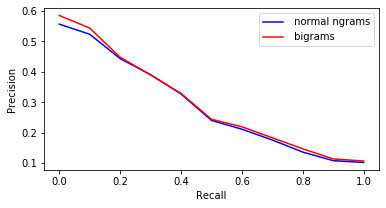

In [9]:
plt.plot(recl[0], np.mean(precl[0],axis=0), color='b', alpha=1,label=' normal ngrams')
plt.plot(recl[1], np.mean(precl[1],axis=0), color='r', alpha=1,label=" bigrams")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=1)
plt.show

In [10]:
recall

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

MAP= 0.2939123097084909


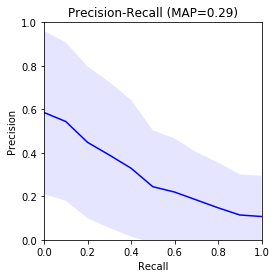

In [11]:
### Show results
print('MAP=',map_vsm)

plt.plot(recall, np.mean(precision_vsm,axis=0), color='b', alpha=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.fill_between(recall, 
                 np.mean(precision_vsm,axis=0)-np.std(precision_vsm,axis=0), 
                 np.mean(precision_vsm,axis=0)+np.std(precision_vsm,axis=0), facecolor='b', alpha=0.1)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall (MAP={0:0.2f})'.format(map_vsm))
plt.savefig('results/prec-recall.png', dpi=100)


In [ ]:
corpus = parser.stemCorpus(cranfield.corpus_cranfield['abstract'])
    
    ### 3. Create the model
    # Compute the term frequencies matrix and the model statistics
tf_cranfield = vectorizer.fit_transform(corpus).toarray()
models = model.RetrievalModelsMatrix(tf_cranfield, vectorizer)

def test_model(rm,par):
    #rm=models.score_lmjm or models.score_ldm
    ### 4. Run the queries over the corpus
    i = 1
    map_vsm = 0
    precision_vsm = []

    for query in cranfield.queries:
        # Parse the query and compute the document scores
        scores = np.nan_to_num(rm(parser.stemSentence(query),par))
        
        # Do the evaluation
        [average_precision, precision, recall, thresholds] = cranfield.eval(scores, i)
        map_vsm = map_vsm + average_precision
        precision_vsm.append(precision)
        
        # Some messages...
        if verbose:
            plt.plot(recall, precision, color='silver', alpha=0.1)
            print('qid =',i, 'VSM     AP=',average_precision)
        
        i = i + 1

    
    map_vsm = map_vsm/cranfield.num_queries
    return map_vsm,recall,precision_vsm

In [ ]:
def m_tests(p_start,p_end,n,model):
    mapl=[]
    recl=[]
    precl=[]

    pv=np.linspace(p_start,p_end,n)
    for p in range(0,n):
        new_map,new_recall,new_precision=test_model(model,pv[p])
        mapl.append(new_map)
        recl.append(new_recall)
        precl.append(new_precision)
    
    ind=np.argmax(mapl)  #finds the index of the biggest map value
    map_vsm=mapl[ind]
    recall=recl[ind]
    precision_vsm=precl[ind]
    best_p=pv[ind]
    return best_p

In [ ]:
m_tests(0.1,1,5,models.score_lmjm)


### Results and discussion


The following table summarizes the MAP and P10 results:

| Retrieval Model | P10 | MAP   |
|-----------------|-----|-------|
| VSM             | ?   | {{map_vsm}} |
| LMD             | ?   | ? |
| LMJM             | ?   | ? |
| BM25             | ?   | ? |

![](results/prec-recall.png)